<a href="https://colab.research.google.com/github/xychong/edgeaimonitoring/blob/main/MobileNet_V2_Training_%5BUnfreeze_Layers_%2B_PTQ%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow.compat.v2 as tf
import keras
from keras.models import Sequential
from keras.applications import mobilenet_v2

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_data.npy", allow_pickle = True)
test_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_data.npy", allow_pickle = True)
train_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_label.npy", allow_pickle = True)
test_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_label.npy", allow_pickle = True)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(2000, 224, 224, 3)
(500, 224, 224, 3)
(2000, 1)
(500, 1)


### Model

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout, Dense
from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D

In [ ]:
original_model = keras.applications.mobilenet_v2.MobileNetV2()

14548992/14536120 [==============================] - 0s 0us/step


In [ ]:
# Original MobileNetV2 architecture
original_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
# Create base model from pre-trained model MobileNetV2
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False)

# Unfreeze the base model
base_model.trainable = True

# Observe how many layers are in the base model
# 154
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 152

# Freeze all layers before 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

for layer in base_model.layers:
  print(layer, layer.trainable)

# Base model architecture
# base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Number of layers in the base model:  154
<keras.engine.input_layer.InputLayer object at 0x7fb33fd737d0> False
<keras.layers.convolutional.Conv2D object at 0x7fb33bbffdd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb33bbec250> False
<keras.layers.advanced_activations.ReLU object at 0x7fb33bbfbfd0> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fb33bbf03d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb33bbfc190> False
<keras.layers.advanced_activations.ReLU object at 0x7fb342bd3790> False
<keras.layers.convolutional.Conv2D object at 0x7fb33bc07650> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb33bc11a50> False
<keras.layers.convolutional.Conv2D object at 0x7fb33bc1ae10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb33bc11e10> False
<keras.lay

In [ ]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

In [ ]:
## Adding additional layers

# Applies average pooling on spatial dimensions
# shape (None, 1280)
x = GlobalAveragePooling2D()(base_model.output) 

# Reshape (None, 1280) to (1, 1, 1280)
x = Reshape((1, 1, 1280))(x)

# Apply a Dropout
# Randomly selected neurons are ignored during training; helps prevent overfitting
# Dropout doesn't have any variables/weights that can be frozen during training
x = Dropout(0.2, name='Dropout')(x) 

# 2D convolutional layer
# Shape (1,1,5)
x = Conv2D(5, (1, 1), padding='same', data_format = 'channels_last')(x)

# Feeds all outputs from previous layers to all neurons
x = Activation('softmax', name='softmax')(x)  

# Reshape (1,1,5) to (,5)
# 5 represents the 5 sound classes
x = Reshape((5,))(x)

model = Model(inputs = base_model.inputs, outputs = x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
model.output

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'reshape_1')>

In [ ]:
# Number of trainable variables
len(model.trainable_variables)

4

In [ ]:
# Configuring the model
# Use crossentropy loss function when there are two or more label classes
# Labels are provided as integers
# Adjust learning rate to reduce loss
opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Train the model
training = model.fit(train_data, train_label, batch_size = 32, epochs=40, validation_data=(test_data, test_label), validation_batch_size = 32, verbose=1)

Epoch 1/40
63/63 [==============================] - 64s 970ms/step - loss: 1.1821 - accuracy: 0.5325 - val_loss: 1.2534 - val_accuracy: 0.3940
Epoch 2/40
63/63 [==============================] - 60s 963ms/step - loss: 0.6591 - accuracy: 0.7840 - val_loss: 0.9636 - val_accuracy: 0.6120
Epoch 3/40
63/63 [==============================] - 60s 963ms/step - loss: 0.5313 - accuracy: 0.8285 - val_loss: 0.8197 - val_accuracy: 0.7060
Epoch 4/40
63/63 [==============================] - 61s 965ms/step - loss: 0.4357 - accuracy: 0.8605 - val_loss: 0.7446 - val_accuracy: 0.7520
Epoch 5/40
63/63 [==============================] - 61s 964ms/step - loss: 0.3938 - accuracy: 0.8690 - val_loss: 0.6686 - val_accuracy: 0.7980
Epoch 6/40
63/63 [==============================] - 60s 961ms/step - loss: 0.3619 - accuracy: 0.8740 - val_loss: 0.6185 - val_accuracy: 0.8220
Epoch 7/40
63/63 [==============================] - 62s 985ms/step - loss: 0.3342 - accuracy: 0.8885 - val_loss: 0.5683 - val_accuracy: 0.8480

### Evaluate Performance of Classifier

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_label)

print("Tested Acc:", test_acc)

16/16 [==============================] - 12s 742ms/step - loss: 0.1444 - accuracy: 0.9520
Tested Acc: 0.9520000219345093


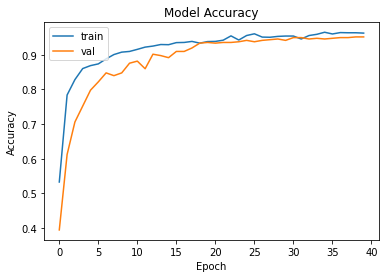

In [ ]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

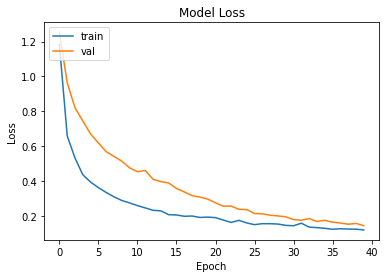

In [ ]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_label_predict = model.predict(test_data)

In [ ]:
# for i in range(500):
#   if np.argmax(test_label_predict[i]) == test_label[i]:
#     print(i)

In [ ]:
print(np.argmax(test_label_predict[0]), test_label[0])
print(np.argmax(test_label_predict[44]), test_label[44])

0 [0]
3 [0]


In [ ]:
sum = 0
for count in range(test_label.shape[0]):
  if np.argmax(test_label_predict[count]) == test_label[count]:
    sum += 1

# Manually verify test accuracy
print(sum/test_label.shape[0])

0.952


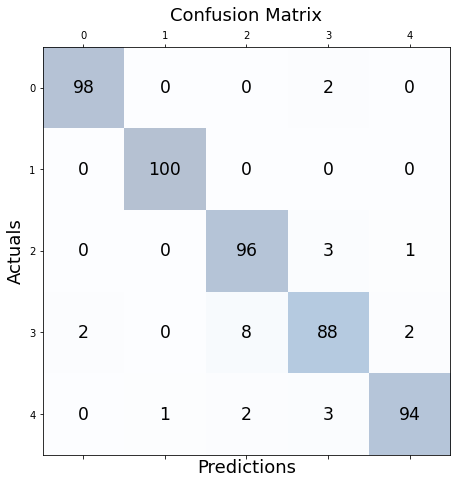

In [ ]:
# Obtain predictions and place it in a new array
test_label_pred_array = []
count = 0
for item in test_label_predict:
  test_label_pred_array.append(np.argmax(test_label_predict[count]))
  count+=1

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_label, test_label_pred_array)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Converting to TFlite

In [ ]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_from_test = np.float32(test_data)
  for i in range(100):
    rep_data = dataset_from_test[5*i] # generate a representative dataset with 100 samples
    final_rep_data = np.expand_dims(rep_data, axis=0)
    yield [final_rep_data]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpnl427b2s/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Compare accuracy

In [ ]:
x = test_data
print(len(x))

500


In [ ]:
interpreter = tf.lite.Interpreter('mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

In [ ]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

[{'dtype': numpy.uint8,
  'index': 0,
  'name': 'input_2',
  'quantization': (0.3137255012989044, 255),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([0.3137255], dtype=float32),
   'zero_points': array([255], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'dtype': numpy.uint8,
  'index': 192,
  'name': 'Identity',
  'quantization': (0.00390625, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([0.00390625], dtype=float32),
   'zero_points': array([0], dtype=int32)},
  'shape': array([1, 5], dtype=int32),
  'shape_signature': array([-1,  5], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = input

def classify_audio(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  top_1 = np.argmax(output)
  return top_1

In [ ]:
tflite_test_label_pred_array = []
sum=0
for count in range(len(test_data)):
  prediction = classify_audio(interpreter, test_data[count])
  tflite_test_label_pred_array.append(prediction)
  if(test_label[count] == prediction):
    sum +=1

#tflite accuracy
print(sum/test_label.shape[0])

0.796


There is an accuracy drop from 95% to 77% after converting to tflite model.

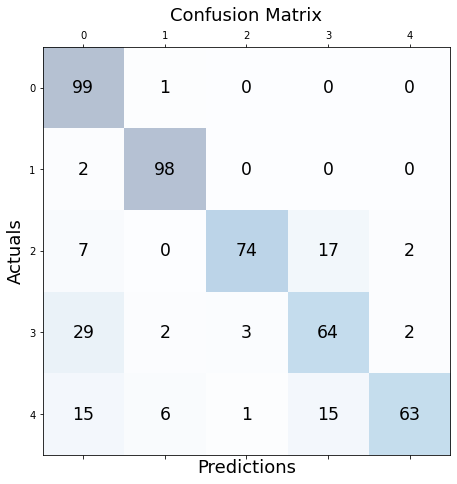

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_label, tflite_test_label_pred_array)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Compile Edge TPU Model

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  74617      0 --:--:-- --:--:-- --:--:-- 74617
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 https://cloud.r-p

In [ ]:
! edgetpu_compiler mobilenet_v2_1.0_224_quant.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.
ERROR: Attempting to use a delegate that only supports static-sized tensors with a graph that has dynamic-sized tensors.
Compilation failed: Model failed in Tflite interpreter. Please ensure model can be loaded/run in Tflite interpreter.
Compilation child process completed within timeout period.
Compilation failed! 


In [ ]:
from google.colab import files

files.download('mobilenet_v2_quant_edgetpu.tflite')